# Near Duplicate Retrieval : For Historical Images

## Imports

In [ ]:
import zipfile
import os
import pandas as pd
import math
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import RandomApply, GaussianBlur
import torchvision.models as models
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import ndcg_score
from scipy.spatial.distance import cosine

import random
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data prep

In [ ]:
root_folder = '/content/drive/MyDrive/projet/'
destination_folder = '/content/drive/MyDrive/near-duplicate-project/test_dataset/'
xlsx_file = root_folder + "new_IS.xlsx"
image_folder = root_folder + "test_dataset/"

Chaque ligne du fichier Excel ```new_IS.xlsx``` représente, dans la première colonne, un fichier original et ses "near duplicates". Je vais construire mon dataset en plaçant le fichier original et tous ses near duplicates dans le même sous-dossier.

In [ ]:
df = pd.read_excel(xlsx_file, header=None)

# Vérifier si le dossier de destination existe, sinon le créer
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Parcourir chaque ligne du DataFrame
for index, row in df.iterrows():
    # Utiliser l'index de la ligne comme nom de classe
    nom_classe = f'classe_{index + 1}'

    # Créer un sous-dossier pour la classe si ce n'est pas déjà fait
    chemin_classe = os.path.join(destination_folder, nom_classe)
    if not os.path.exists(chemin_classe):
        os.makedirs(chemin_classe)

    # Copier les images associées de image_folder vers le sous-dossier de la classe
    for image_name in row.dropna():  # Ignorer les valeurs NaN
        source_image_path = os.path.join(image_folder, image_name)
        destination_image_path = os.path.join(chemin_classe, image_name)

        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, destination_image_path)
        else:
            print(f"Image {image_name} not found in {image_folder}")

print("Dataset créé avec succès.")

Dataset créé avec succès.


In [ ]:
def count_images_in_folder(folder_path):
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        image_count = sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg')))
        #print(f"Nombre d'images dans {root}: {image_count}")
        total_images += image_count
    return total_images

print(count_images_in_folder('/content/drive/MyDrive/near-duplicate-project/test_dataset'))

274


J'ai ensuite créé un dataset augmenté où j'ai séparé mon dataset en 3 parties : train 70 %, validation 18 % et test 12 %

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from torchvision import transforms
import torch
import random

# Define augmentation transformations
transform_list = [
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
]

# Custom function to add noise
def add_noise(image):
    image_array = np.array(image)
    noise = np.random.normal(0, 25, image_array.shape)
    noisy_image = image_array + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

# Custom function to apply affine transformations
def affine_transform(image):
    rows, cols = image.size
    pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
    pts2 = np.float32([[10, 100], [200, 50], [100, 250]])
    M = cv2.getAffineTransform(pts1, pts2)
    dst = cv2.warpAffine(np.array(image), M, (cols, rows))
    return Image.fromarray(dst)

# Custom function to apply erosion and dilation
def erode_dilate(image):
    image_array = np.array(image)
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(image_array, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    return Image.fromarray(dilated)

# Compose transformations
transform = transforms.Compose(transform_list)

# Paths
source_dir = '/content/drive/MyDrive/near-duplicate-project/test_dataset'
target_dir = '/content/drive/MyDrive/near-duplicate-project/dataset_final'

# Number of augmentations per image
num_augmentations = 8

# Create target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Function to apply all transformations
def augment_image(image):
    # Convert to grayscale and apply basic transformations
    image = transform(image)
    image = transforms.ToPILImage()(image)

    # Randomly apply additional custom transformations
    if random.random() > 0.5:
        image = ImageEnhance.Brightness(image).enhance(random.uniform(0.3, 1.5))
    if random.random() > 0.5:
        image = add_noise(image)
    if random.random() > 0.5:
        image = affine_transform(image)
    if random.random() > 0.5:
        image = erode_dilate(image)

    return image

# Process each image in the dataset
for subdir, dirs, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(subdir, file)
            image = Image.open(image_path).convert('RGB')

            # Augment the image multiple times
            for i in range(num_augmentations):  # Number of augmentations per image
                augmented_image = augment_image(image)
                target_subdir = subdir.replace(source_dir, target_dir)
                if not os.path.exists(target_subdir):
                    os.makedirs(target_subdir)

                base, ext = os.path.splitext(file)
                augmented_image_path = os.path.join(target_subdir, f"{base}_aug_{i}{ext}")
                augmented_image.save(augmented_image_path)

print("Data augmentation complete.")


Data augmentation complete.


In [ ]:
print(count_images_in_folder('/content/drive/MyDrive/near-duplicate-project/dataset_final'))

2192


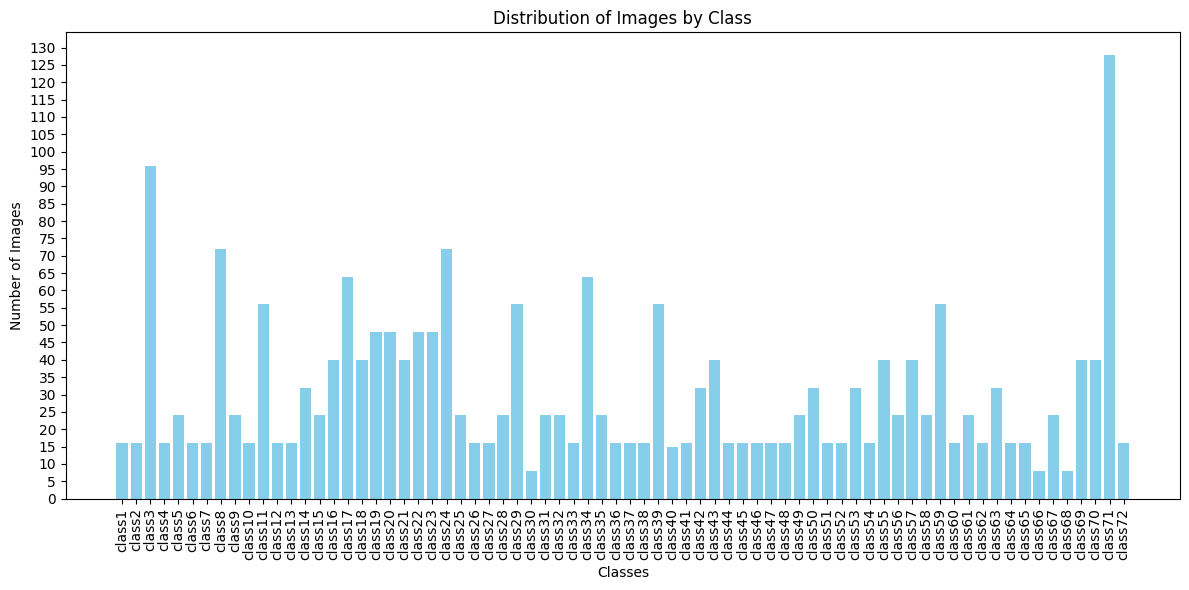

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the path to the clean dataset
dataset_dir = '/content/drive/MyDrive/near-duplicate-project/dataset_final'

# Get the list of classes (subdirectories in the dataset directory)
classes = sorted(os.listdir(dataset_dir))

# Count the number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in classes}

# Extract class names and counts for plotting
class_names = [f'class{i+1}' for i in range(len(classes))]
image_counts = list(class_counts.values())

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Class')
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.yticks(range(0, max(image_counts) + 5, 5))  # Set y-axis ticks in increments of 5
plt.tight_layout()
plt.show()


In [ ]:
def copy_folder_contents(classes, destination_folder):
    for class_folder in classes:
        source_folder = os.path.join(original_dataset_folder, class_folder)
        destination_class_folder = os.path.join(destination_folder, class_folder)
        if not os.path.exists(destination_class_folder):
            os.makedirs(destination_class_folder)
        for file_name in os.listdir(source_folder):
            source_file_path = os.path.join(source_folder, file_name)
            destination_file_path = os.path.join(destination_class_folder, file_name)
            shutil.copy(source_file_path, destination_file_path)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dataset_folder = '/content/drive/MyDrive/near-duplicate-project/dataset_final/'
clean_dataset_folder = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/'

train_folder = os.path.join(clean_dataset_folder, 'train')
val_folder = os.path.join(clean_dataset_folder, 'val')
test_folder = os.path.join(clean_dataset_folder, 'test')

for folder in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

all_classes = [d for d in os.listdir(original_dataset_folder) if os.path.isdir(os.path.join(original_dataset_folder, d))]

# Split the folders into train, val, and test sets
train_classes, temp_classes = train_test_split(all_classes, test_size=0.3, random_state=42)
val_classes, test_classes = train_test_split(temp_classes, test_size=0.5, random_state=42)

copy_folder_contents(train_classes, train_folder)
copy_folder_contents(val_classes, val_folder)
copy_folder_contents(test_classes, test_folder)

print("Dataset créé")

train_folder = os.path.join(clean_dataset_folder, 'train')
val_folder = os.path.join(clean_dataset_folder, 'val')
test_folder = os.path.join(clean_dataset_folder, 'test')

# Compter les images dans chaque dossier
total_train_images = count_images_in_folder(train_folder)
total_val_images = count_images_in_folder(val_folder)
total_test_images = count_images_in_folder(test_folder)

print(f"Total d'images dans Train: {total_train_images}")
print(f"Total d'images dans Val: {total_val_images}")
print(f"Total d'images dans Test: {total_test_images}")



Dataset créé
Total d'images dans Train: 1520
Total d'images dans Val: 408
Total d'images dans Test: 264


## Modelisation

## Triplet Loss Model

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        #self.resnet = models.resnet152(pretrained=True)
        self.resnet = models.resnet34(weights="IMAGENET1K_V1")
        # Remove the last classification layer
        #self.resnet.fc = nn.Identity()
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        return self.resnet(x)



In [ ]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = self._load_image_paths()
        print("Number of images loaded:", len(self.image_paths))


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor_img = Image.open(anchor_path).convert('RGB')
        positive_path = self._find_near_duplicate(anchor_path)
        positive_img = Image.open(positive_path).convert('RGB')
        negative_path = self._find_negative(anchor_path)
        negative_img = Image.open(negative_path).convert('RGB')

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

    def _load_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def _find_near_duplicate(self, anchor_path):
        anchor_folder = os.path.dirname(anchor_path)
        candidate_paths = [path for path in self.image_paths if os.path.dirname(path) == anchor_folder and path != anchor_path]
        return random.choice(candidate_paths)

    def _find_negative(self, anchor_path):
        candidate_paths = [path for path in self.image_paths if os.path.dirname(path) != os.path.dirname(anchor_path)]
        return random.choice(candidate_paths)

## Training & Validation (Triplet Margin Loss)


### Triplet Loss

In [ ]:
import csv

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions, total_predictions = 0, 0

        for anchor, positive, negative in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            optimizer.zero_grad()
            output_anchor = model(anchor)
            output_positive = model(positive)
            output_negative = model(negative)
            loss = criterion(output_anchor, output_positive, output_negative)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            distance_positive = (output_anchor - output_positive).pow(2).sum(1)
            distance_negative = (output_anchor - output_negative).pow(2).sum(1)
            correct_predictions += (distance_negative > distance_positive).sum().item()
            total_predictions += anchor.size(0)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_precision = correct_predictions / total_predictions
        train_precisions.append(train_precision)
        train_recall = correct_predictions / total_predictions
        train_recalls.append(train_recall)
        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) != 0 else 0
        train_f1s.append(train_f1)

        val_loss, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}")

    return train_losses, val_losses, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s

# Validate function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            output_anchor = model(anchor)
            output_positive = model(positive)
            output_negative = model(negative)
            loss = criterion(output_anchor, output_positive, output_negative)
            val_loss += loss.item()

            distance_positive = (output_anchor - output_positive).pow(2).sum(1)
            distance_negative = (output_anchor - output_negative).pow(2).sum(1)
            correct_predictions += (distance_negative > distance_positive).sum().item()
            total_predictions += anchor.size(0)

    val_loss /= len(val_loader)
    precision = correct_predictions / total_predictions
    recall = correct_predictions / total_predictions
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return val_loss, precision, recall, f1_score

# Evaluate function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            output_anchor = model(anchor)
            output_positive = model(positive)
            output_negative = model(negative)
            loss = criterion(output_anchor, output_positive, output_negative)
            test_loss += loss.item()

            distance_positive = (output_anchor - output_positive).pow(2).sum(1)
            distance_negative = (output_anchor - output_negative).pow(2).sum(1)
            correct_predictions += (distance_negative > distance_positive).sum().item()
            total_predictions += anchor.size(0)

    test_loss /= len(test_loader)
    accuracy = correct_predictions / total_predictions
    precision = correct_predictions / (correct_predictions + (total_predictions - correct_predictions))
    recall = correct_predictions / total_predictions
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return test_loss, accuracy, precision, recall, f1_score

# Save the trained model weights
def save_model_weights(model, path):
    torch.save(model.state_dict(), path)


In [ ]:
# Model and DataLoader setup
num_epochs= 25

model = TransferLearningModel().cuda()
#model.load_state_dict(torch.load('/content/drive/MyDrive/near-duplicate-project/weight/model_resnet34_2_epochs_v4.pth'))
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(400),
    #transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define directories for train, validation, and test datasets
train_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/train'
val_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/val'
test_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/test'

train_dataset = TripletDataset(root_dir=train_dir, transform=transform)
val_dataset = TripletDataset(root_dir=val_dir, transform=transform)
test_dataset = TripletDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses, val_losses, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Save model weights
save_model_weights(model, '/content/drive/MyDrive/near-duplicate-project/weight/triplet/model_resnet34_25_epochs_triplet_v4.pth')

# Save metrics to CSV
metrics = {
    "epoch": list(range(1, num_epochs + 1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_precision": train_precisions,
    "val_precision": val_precisions,
    "train_recall": train_recalls,
    "val_recall": val_recalls,
    "train_f1": train_f1s,
    "val_f1": val_f1s
}

csv_file_path = '/content/drive/MyDrive/near-duplicate-project/metrics/metrics_triplet.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(metrics.keys())
    writer.writerows(zip(*metrics.values()))

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)

Number of images loaded: 1512
Number of images loaded: 408
Number of images loaded: 264


Epoch 1/25: 100%|██████████| 48/48 [11:28<00:00, 14.35s/it]


Epoch [1/25], Train Loss: 42.52875097716848, Validation Loss: 176.0650406892483


Epoch 2/25: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


Epoch [2/25], Train Loss: 1.7990271517386038, Validation Loss: 1501.7809282082778


Epoch 3/25: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


Epoch [3/25], Train Loss: 1.0677036345005035, Validation Loss: 313.56587908359677


Epoch 4/25: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


Epoch [4/25], Train Loss: 0.9987107813358307, Validation Loss: 457.9702398685309


Epoch 5/25: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


Epoch [5/25], Train Loss: 0.9803589135408401, Validation Loss: 152.77708745919742


Epoch 6/25: 100%|██████████| 48/48 [01:12<00:00,  1.51s/it]


Epoch [6/25], Train Loss: 0.8960076260070006, Validation Loss: 172.591442323648


Epoch 7/25: 100%|██████████| 48/48 [01:12<00:00,  1.52s/it]


Epoch [7/25], Train Loss: 0.9117858881751696, Validation Loss: 208.02413137600973


Epoch 8/25: 100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Epoch [8/25], Train Loss: 0.9216118641197681, Validation Loss: 797.1635818206347


Epoch 9/25: 100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Epoch [9/25], Train Loss: 0.8913426709671816, Validation Loss: 1053.9828340640436


Epoch 10/25: 100%|██████████| 48/48 [01:12<00:00,  1.52s/it]


Epoch [10/25], Train Loss: 1.0371207613497972, Validation Loss: 81.323362497183


Epoch 11/25: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Epoch [11/25], Train Loss: 1.0, Validation Loss: 127.25507046626164


Epoch 12/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [12/25], Train Loss: 1.0, Validation Loss: 128.48801568838266


Epoch 13/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [13/25], Train Loss: 1.0, Validation Loss: 88.51889771681566


Epoch 14/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [14/25], Train Loss: 1.0, Validation Loss: 144.35801765551935


Epoch 15/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [15/25], Train Loss: 1.0, Validation Loss: 137.7289528479943


Epoch 16/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [16/25], Train Loss: 1.0, Validation Loss: 103.45931322299518


Epoch 17/25: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Epoch [17/25], Train Loss: 1.0, Validation Loss: 132.051469876216


Epoch 18/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [18/25], Train Loss: 1.0, Validation Loss: 123.65808985783504


Epoch 19/25: 100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


Epoch [19/25], Train Loss: 1.0, Validation Loss: 188.8692116370568


Epoch 20/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [20/25], Train Loss: 1.0, Validation Loss: 299.2689547171959


Epoch 21/25: 100%|██████████| 48/48 [01:10<00:00,  1.48s/it]


Epoch [21/25], Train Loss: 1.0, Validation Loss: 129.43137692488156


Epoch 22/25: 100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


Epoch [22/25], Train Loss: 1.0, Validation Loss: 170.09022052471454


Epoch 23/25: 100%|██████████| 48/48 [01:10<00:00,  1.48s/it]


Epoch [23/25], Train Loss: 1.0, Validation Loss: 216.8797791325129


Epoch 24/25: 100%|██████████| 48/48 [01:11<00:00,  1.48s/it]


Epoch [24/25], Train Loss: 1.0, Validation Loss: 163.22301776592548


Epoch 25/25: 100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


Epoch [25/25], Train Loss: 1.0, Validation Loss: 139.92920332688553


In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)

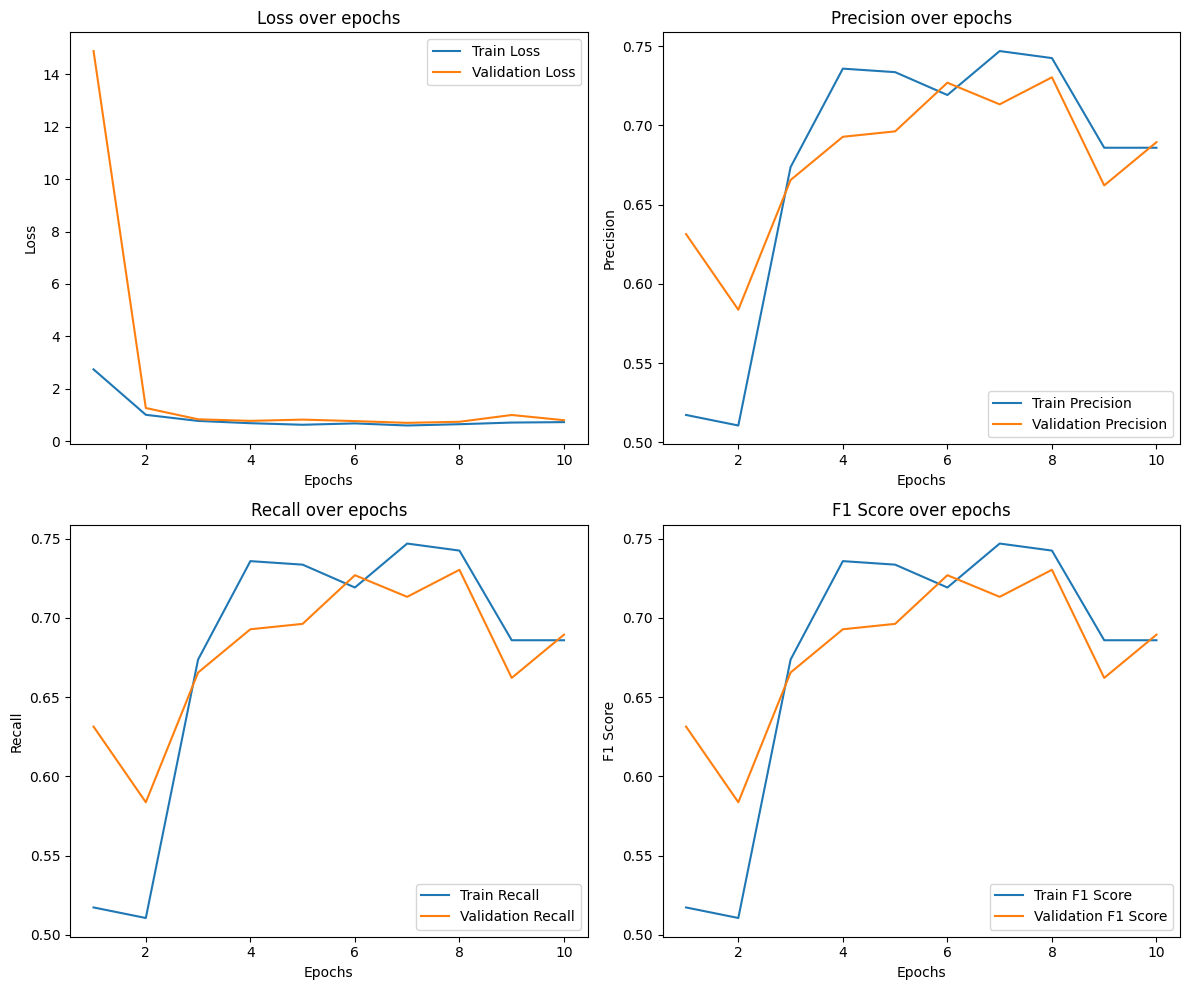

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label='Train F1 Score')
plt.plot(epochs, val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Training & Validation (Cross-entropy Loss)


### CrossEntropy

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust to accept 3 channels
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = self._load_image_paths_and_labels()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        class_folders = sorted(os.listdir(self.root_dir))
        for idx, class_folder in enumerate(class_folders):
            class_folder_path = os.path.join(self.root_dir, class_folder)
            if os.path.isdir(class_folder_path):
                for file in os.listdir(class_folder_path):
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(class_folder_path, file))
                        labels.append(idx)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_predictions, total_predictions = 0.0, 0, 0
        all_labels, all_preds = [], []

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        train_losses.append(train_loss)

        train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        val_loss, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    return train_losses, val_losses, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return val_loss, val_precision, val_recall, val_f1

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss /= len(test_loader)
    test_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    test_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {correct_predictions / total_predictions * 100:.2f}%, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
    return test_loss, correct_predictions / total_predictions, test_precision, test_recall, test_f1


In [ ]:
train_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/train'
val_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/val'
test_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/test'

In [ ]:
# Model and DataLoader setup
num_classes = len(os.listdir(train_dir))  # Number of classes based on subdirectories in train_dir
num_epochs = 25

model = TransferLearningModel(num_classes=num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(400),
    transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ClassificationDataset(root_dir=train_dir, transform=transform)
val_dataset = ClassificationDataset(root_dir=val_dir, transform=transform)
test_dataset = ClassificationDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_losses, val_losses, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

Epoch 1/25: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch [1/25], Train Loss: 4.3401, Precision: 0.0179, Recall: 0.0227, F1: 0.0124
Validation Loss: 5.5420, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 2/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [2/25], Train Loss: 3.7356, Precision: 0.0091, Recall: 0.0225, F1: 0.0089
Validation Loss: 4.4214, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 3/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [3/25], Train Loss: 3.6034, Precision: 0.0176, Recall: 0.0282, F1: 0.0164
Validation Loss: 7.3233, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 4/25: 100%|██████████| 48/48 [00:17<00:00,  2.71it/s]


Epoch [4/25], Train Loss: 3.4760, Precision: 0.0516, Recall: 0.0409, F1: 0.0256
Validation Loss: 4.7066, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 5/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [5/25], Train Loss: 3.3569, Precision: 0.0375, Recall: 0.0483, F1: 0.0372
Validation Loss: 6.3415, Precision: 0.0083, Recall: 0.0028, F1: 0.0042


Epoch 6/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [6/25], Train Loss: 3.3013, Precision: 0.0454, Recall: 0.0535, F1: 0.0424
Validation Loss: 5.6063, Precision: 0.0691, Recall: 0.0192, F1: 0.0278


Epoch 7/25: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch [7/25], Train Loss: 3.2177, Precision: 0.0745, Recall: 0.0753, F1: 0.0620
Validation Loss: 32.9483, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


Epoch 8/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [8/25], Train Loss: 3.1518, Precision: 0.0913, Recall: 0.1000, F1: 0.0838
Validation Loss: 6.4950, Precision: 0.0426, Recall: 0.0217, F1: 0.0240


Epoch 9/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [9/25], Train Loss: 3.0048, Precision: 0.1378, Recall: 0.1262, F1: 0.1160
Validation Loss: 6.8188, Precision: 0.0742, Recall: 0.0230, F1: 0.0349


Epoch 10/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [10/25], Train Loss: 2.8760, Precision: 0.1717, Recall: 0.1364, F1: 0.1309
Validation Loss: 7.3814, Precision: 0.0120, Recall: 0.0010, F1: 0.0013


Epoch 11/25: 100%|██████████| 48/48 [00:18<00:00,  2.66it/s]


Epoch [11/25], Train Loss: 2.6321, Precision: 0.2212, Recall: 0.1973, F1: 0.1954
Validation Loss: 7.1154, Precision: 0.0604, Recall: 0.0143, F1: 0.0184


Epoch 12/25: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch [12/25], Train Loss: 2.4257, Precision: 0.2730, Recall: 0.2480, F1: 0.2421
Validation Loss: 19.2205, Precision: 0.0570, Recall: 0.0028, F1: 0.0050


Epoch 13/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [13/25], Train Loss: 2.2139, Precision: 0.3203, Recall: 0.3007, F1: 0.2940
Validation Loss: 11.8669, Precision: 0.0248, Recall: 0.0016, F1: 0.0030


Epoch 14/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [14/25], Train Loss: 1.9551, Precision: 0.4173, Recall: 0.3758, F1: 0.3812
Validation Loss: 11.0369, Precision: 0.0407, Recall: 0.0105, F1: 0.0097


Epoch 15/25: 100%|██████████| 48/48 [00:17<00:00,  2.67it/s]


Epoch [15/25], Train Loss: 1.7410, Precision: 0.4711, Recall: 0.4511, F1: 0.4465
Validation Loss: 9.6730, Precision: 0.0123, Recall: 0.0035, F1: 0.0046


Epoch 16/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [16/25], Train Loss: 1.4779, Precision: 0.5752, Recall: 0.5256, F1: 0.5310
Validation Loss: 22.6551, Precision: 0.0188, Recall: 0.0024, F1: 0.0039


Epoch 17/25: 100%|██████████| 48/48 [00:17<00:00,  2.71it/s]


Epoch [17/25], Train Loss: 1.1655, Precision: 0.6316, Recall: 0.5880, F1: 0.5974
Validation Loss: 13.8026, Precision: 0.0259, Recall: 0.0049, F1: 0.0070


Epoch 18/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [18/25], Train Loss: 1.0450, Precision: 0.7154, Recall: 0.6511, F1: 0.6628
Validation Loss: 12.5421, Precision: 0.0053, Recall: 0.0025, F1: 0.0034


Epoch 19/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [19/25], Train Loss: 1.0764, Precision: 0.6676, Recall: 0.6284, F1: 0.6393
Validation Loss: 14.9788, Precision: 0.0504, Recall: 0.0076, F1: 0.0102


Epoch 20/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [20/25], Train Loss: 0.6857, Precision: 0.7988, Recall: 0.7651, F1: 0.7749
Validation Loss: 13.5299, Precision: 0.0210, Recall: 0.0159, F1: 0.0096


Epoch 21/25: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch [21/25], Train Loss: 0.6176, Precision: 0.8010, Recall: 0.7715, F1: 0.7800
Validation Loss: 13.0743, Precision: 0.0140, Recall: 0.0021, F1: 0.0036


Epoch 22/25: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch [22/25], Train Loss: 0.5550, Precision: 0.8064, Recall: 0.7880, F1: 0.7918
Validation Loss: 11.9552, Precision: 0.0558, Recall: 0.0138, F1: 0.0193


Epoch 23/25: 100%|██████████| 48/48 [00:17<00:00,  2.70it/s]


Epoch [23/25], Train Loss: 0.3468, Precision: 0.8980, Recall: 0.8687, F1: 0.8775
Validation Loss: 12.9485, Precision: 0.0228, Recall: 0.0082, F1: 0.0118


Epoch 24/25: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


Epoch [24/25], Train Loss: 0.4661, Precision: 0.8525, Recall: 0.8475, F1: 0.8470
Validation Loss: 10.9468, Precision: 0.0770, Recall: 0.0207, F1: 0.0287


Epoch 25/25: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


Epoch [25/25], Train Loss: 0.3513, Precision: 0.8828, Recall: 0.8580, F1: 0.8645
Validation Loss: 11.9944, Precision: 0.0169, Recall: 0.0111, F1: 0.0129


In [ ]:

# Save model weights
save_model_weights(model, '/content/drive/MyDrive/near-duplicate-project/weight/crossentropy/model_resnet34_25_epochs_crossentropy_v1.pth')

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)

# Save metrics to CSV
metrics = {
    "epoch": list(range(1, num_epochs + 1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_precision": train_precisions,
    "val_precision": val_precisions,
    "train_recall": train_recalls,
    "val_recall": val_recalls,
    "train_f1": train_f1s,
    "val_f1": val_f1s
}

csv_file_path = '/content/drive/MyDrive/near-duplicate-project/metrics/metrics_restnet34_25_epochs_crossentropy.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(metrics.keys())
    writer.writerows(zip(*metrics.values()))

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)

Test Loss: 14.2126, Test Accuracy: 4.17%, Precision: 0.0318, Recall: 0.0078, F1: 0.0124
Test Loss: 14.1571, Test Accuracy: 4.17%, Precision: 0.0278, Recall: 0.0069, F1: 0.0111


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion)

Test Loss: 15.345282173156738, Test Accuracy: 1.59%


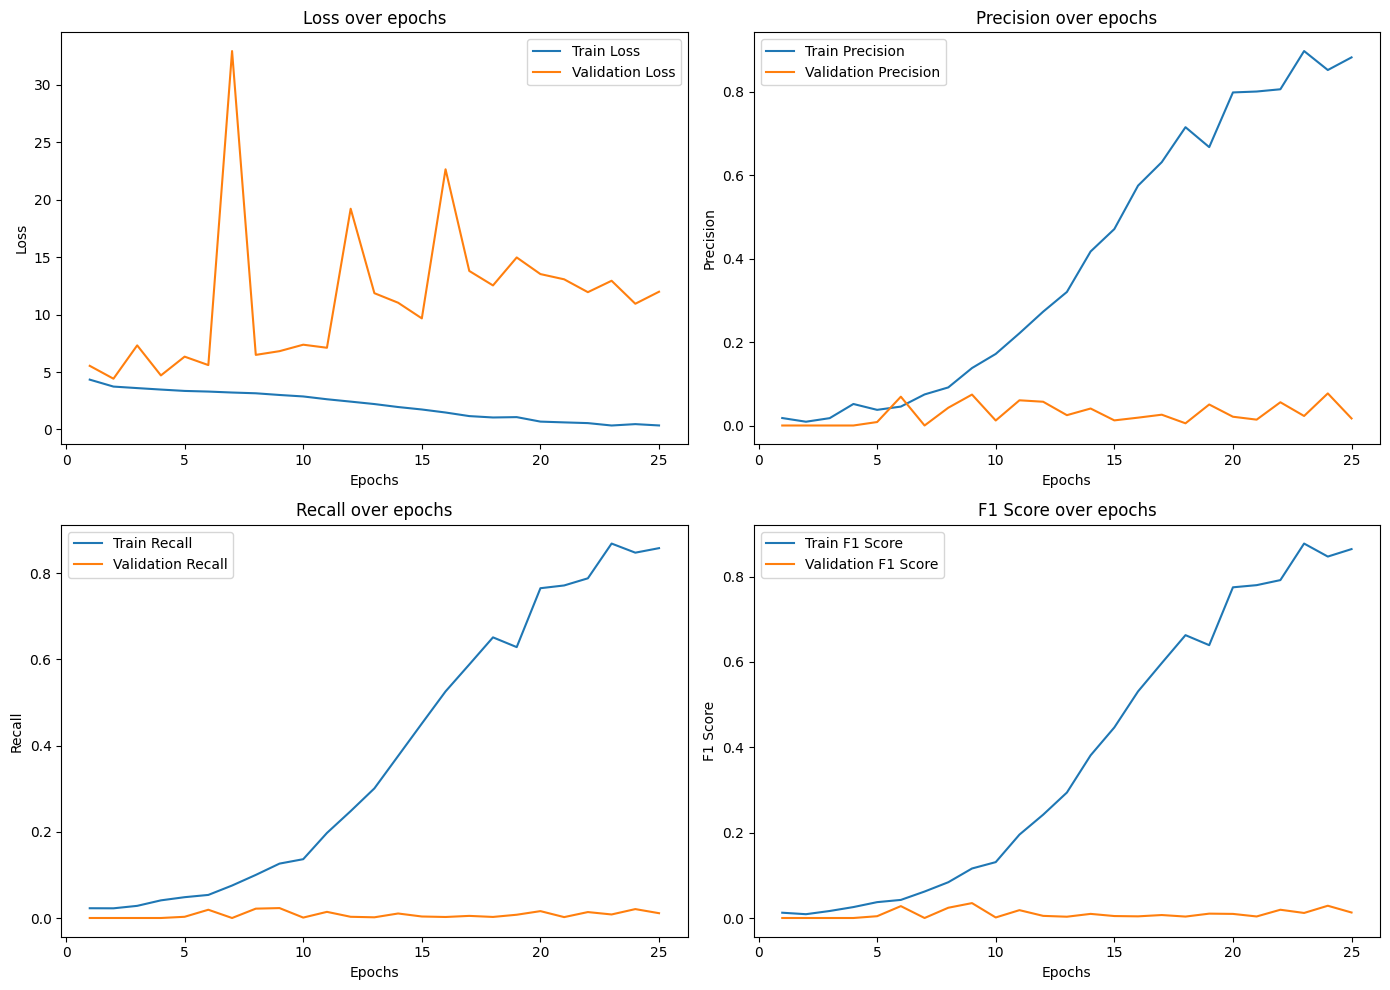

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics CSV file
csv_file_path = '/content/drive/MyDrive/near-duplicate-project/metrics/metrics_restnet34_25_epochs_crossentropy.csv'
metrics_df = pd.read_csv(csv_file_path)

# Plotting the metrics
epochs = metrics_df['epoch']

plt.figure(figsize=(14, 10))

# Plot Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, metrics_df['train_loss'], label='Train Loss')
plt.plot(epochs, metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# Plot Training and Validation Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, metrics_df['train_precision'], label='Train Precision')
plt.plot(epochs, metrics_df['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over epochs')
plt.legend()

# Plot Training and Validation Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, metrics_df['train_recall'], label='Train Recall')
plt.plot(epochs, metrics_df['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over epochs')
plt.legend()

# Plot Training and Validation F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, metrics_df['train_f1'], label='Train F1 Score')
plt.plot(epochs, metrics_df['val_f1'], label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over epochs')
plt.legend()

plt.tight_layout()
plt.show()


## Tache : Near Duplicate Retrieval

##Cross Entropy

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.metrics import ndcg_score
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import csv

# Define the TransferLearningModel for embedding extraction
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust to accept 3 channels
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Define a model for embedding extraction
class EmbeddingModel(nn.Module):
    def __init__(self, resnet_model):
        super(EmbeddingModel, self).__init__()
        self.resnet = resnet_model
        self.resnet.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        return self.resnet(x)

# Load the mapping CSV file
csv_file_path = '/content/drive/MyDrive/near-duplicate-project/prediction/mapping.csv'
mapping = {}
with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        mapping[row[0]] = row[1]

num_classes = len(set(mapping.values()))
trained_model = TransferLearningModel(num_classes=50).cuda()
trained_model.load_state_dict(torch.load('/content/drive/MyDrive/near-duplicate-project/weight/crossentropy/model_resnet34_25_epochs_crossentropy_v1.pth'))
embedding_model = EmbeddingModel(trained_model).cuda()
embedding_model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(400),
    transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load and transform an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).cuda()
    return image

# Function to get image embeddings
def get_embeddings(model, image_paths):
    embeddings = []
    for image_path in image_paths:
        image = load_image(image_path)
        with torch.no_grad():
            embedding = model(image).cpu().numpy().flatten()
        embeddings.append(embedding)
    return np.array(embeddings)

# Define the dataset directory
dataset_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/prediction/'

# Get the list of image paths and their corresponding classes
image_paths = [os.path.join(dataset_dir, os.path.basename(img)) for img in mapping.keys()]
classes = [mapping[os.path.basename(image_path)] for image_path in image_paths]

# Get embeddings for all images
embeddings = get_embeddings(embedding_model, image_paths)

# Apply PCA to reduce dimensionality
n_components = min(256, embeddings.shape[0], embeddings.shape[1])
pca = PCA(n_components=n_components)
pca_embeddings = pca.fit_transform(embeddings)

# Function to compute cosine similarity
def cosine_similarity(a, b):
    return 1 - cosine(a, b)

# Function to evaluate retrieval performance and display top N similar images
def evaluate_retrieval(pca_embeddings, classes, image_paths, top_k=5):
    ndcg_scores = []
    top_k_accuracies = []

    for i in range(len(pca_embeddings)):
        query_embedding = pca_embeddings[i]
        query_class = classes[i]
        similarities = [cosine_similarity(query_embedding, emb) for emb in pca_embeddings]

        # Get top k indices excluding the query image itself
        top_k_indices = np.argsort(similarities)[::-1][1:top_k+1]
        top_k_classes = [classes[idx] for idx in top_k_indices]
        top_k_similarities = [similarities[idx] for idx in top_k_indices]

        # Ensure the lengths match for nDCG computation
        if len(top_k_classes) < top_k:
            top_k_classes += [None] * (top_k - len(top_k_classes))
            top_k_similarities += [0] * (top_k - len(top_k_similarities))

        # Compute top k accuracy
        top_k_accuracy = sum(1 for cls in top_k_classes if cls == query_class) / top_k
        top_k_accuracies.append(top_k_accuracy)

        # Compute nDCG score
        true_relevance = [1 if cls == query_class else 0 for cls in top_k_classes]
        ndcg = ndcg_score([true_relevance], [top_k_similarities])
        ndcg_scores.append(ndcg)

        # Display the query image and top N similar images
        fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 10))
        query_image = Image.open(image_paths[i]).convert('L')
        axes[0].imshow(query_image, cmap='gray')
        axes[0].set_title(f"Query Image\nClass: {query_class}")
        axes[0].axis('off')

        for j, idx in enumerate(top_k_indices):
            similar_image_path = image_paths[idx]
            similar_image = Image.open(similar_image_path).convert('L')
            ax = axes[j + 1]
            ax.imshow(similar_image, cmap='gray')
            ax.set_title(f"Class: {top_k_classes[j]}\nScore: {top_k_similarities[j]:.4f}")
            ax.axis('off')
        plt.tight_layout()
        plt.suptitle(f"Query: {os.path.basename(image_paths[i])}")
        plt.show()

    mean_ndcg = np.mean(ndcg_scores)
    mean_top_k_accuracy = np.mean(top_k_accuracies)

    return mean_ndcg, mean_top_k_accuracy

# Evaluate retrieval performance
mean_ndcg, mean_top_k_accuracy = evaluate_retrieval(pca_embeddings, classes, image_paths, top_k=5)

print(f"Mean nDCG: {mean_ndcg:.4f}")
print(f"Mean Top-5 Accuracy: {mean_top_k_accuracy:.4f}")


## Triplet Margin Loss

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )

    def forward(self, x):
        return self.resnet(x)

class EmbeddingModel(nn.Module):
    def __init__(self, resnet_model):
        super(EmbeddingModel, self).__init__()
        self.resnet = resnet_model
        self.resnet.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        return self.resnet(x)

# Load the mapping CSV file
csv_file_path = '/content/drive/MyDrive/near-duplicate-project/prediction/mapping.csv'
mapping = {}
with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    for row in reader:
        mapping[row[0]] = row[1]

trained_model = TransferLearningModel().cuda()
trained_model.load_state_dict(torch.load('/content/drive/MyDrive/near-duplicate-project/weight/triplet/model_resnet34_triplet_25_epochs.pth'))
embedding_model = EmbeddingModel(trained_model).cuda()
embedding_model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(400),
    transforms.CenterCrop(350),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load and transform an image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).cuda()
    return image

# Function to get image embeddings
def get_embeddings(model, image_paths):
    embeddings = []
    for image_path in image_paths:
        image = load_image(image_path)
        with torch.no_grad():
            embedding = model(image).cpu().numpy().flatten()
        embeddings.append(embedding)
    return np.array(embeddings)

# Define the dataset directory
dataset_dir = '/content/drive/MyDrive/near-duplicate-project/clean_dataset/prediction/'

# Get the list of image paths and their corresponding classes
image_paths = [os.path.join(dataset_dir, os.path.basename(img)) for img in mapping.keys()]
classes = [mapping[os.path.basename(image_path)] for image_path in image_paths]

# Get embeddings for all images
embeddings = get_embeddings(embedding_model, image_paths)

# Apply PCA to reduce dimensionality
n_components = min(256, embeddings.shape[0], embeddings.shape[1])
pca = PCA(n_components=n_components)
pca_embeddings = pca.fit_transform(embeddings)

# Function to compute cosine similarity
def cosine_similarity(a, b):
    return 1 - cosine(a, b)

# Function to evaluate retrieval performance and display top N similar images
def evaluate_retrieval(pca_embeddings, classes, image_paths, top_k=5):
    ndcg_scores = []
    top_k_accuracies = []

    for i in range(len(pca_embeddings)):
        query_embedding = pca_embeddings[i]
        query_class = classes[i]
        similarities = [cosine_similarity(query_embedding, emb) for emb in pca_embeddings]

        # Get top k indices excluding the query image itself
        top_k_indices = np.argsort(similarities)[::-1][1:top_k+1]
        top_k_classes = [classes[idx] for idx in top_k_indices]
        top_k_similarities = [similarities[idx] for idx in top_k_indices]

        # Ensure the lengths match for nDCG computation
        if len(top_k_classes) < top_k:
            top_k_classes += [None] * (top_k - len(top_k_classes))
            top_k_similarities += [0] * (top_k - len(top_k_similarities))

        # Compute top k accuracy
        top_k_accuracy = sum(1 for cls in top_k_classes if cls == query_class) / top_k
        top_k_accuracies.append(top_k_accuracy)

        # Compute nDCG score
        true_relevance = [1 if cls == query_class else 0 for cls in top_k_classes]
        ndcg = ndcg_score([true_relevance], [top_k_similarities])
        ndcg_scores.append(ndcg)

        # Display the query image and top N similar images
        fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 10))
        query_image = Image.open(image_paths[i]).convert('L')
        axes[0].imshow(query_image, cmap='gray')
        axes[0].set_title(f"Query Image\nClass: {query_class}")
        axes[0].axis('off')

        for j, idx in enumerate(top_k_indices):
            similar_image_path = image_paths[idx]
            similar_image = Image.open(similar_image_path).convert('L')
            ax = axes[j + 1]
            ax.imshow(similar_image, cmap='gray')
            ax.set_title(f"Class: {top_k_classes[j]}\nScore: {top_k_similarities[j]:.4f}")
            ax.axis('off')
        plt.tight_layout()
        plt.suptitle(f"Query: {os.path.basename(image_paths[i])}")
        plt.show()

    mean_ndcg = np.mean(ndcg_scores)
    mean_top_k_accuracy = np.mean(top_k_accuracies)

    return mean_ndcg, mean_top_k_accuracy

# Evaluate retrieval performance
mean_ndcg, mean_top_k_accuracy = evaluate_retrieval(pca_embeddings, classes, image_paths, top_k=5)

print(f"Mean nDCG: {mean_ndcg:.4f}")
print(f"Mean Top-5 Accuracy: {mean_top_k_accuracy:.4f}")
